# Creating the boundary forcing

In [1]:
from roms_tools import Grid, BoundaryForcing

As always, the first step is to create our grid. In this example, we choose a grid that contains Greenland's south east coast and the Irminger Sea. The grid has a horizontal resolution of 2 km and 100 vertical layers.

In [2]:
grid = Grid(
    nx=500,
    ny=500,
    size_x=1000,
    size_y=1000,
    center_lon=-37,
    center_lat=64,
    rot=25,
    N=100,
    topography_source={
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    },
)

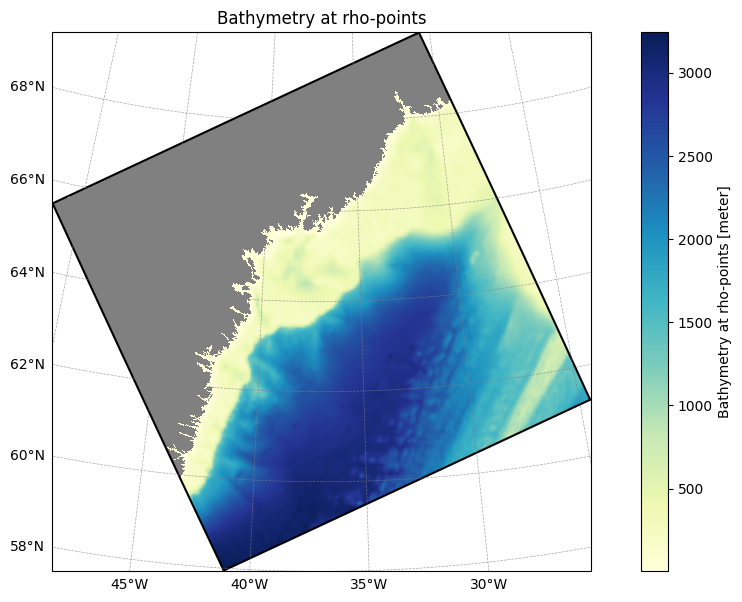

In [3]:
grid.plot()

Note that the northern boundary lies entirely on land, so we can exclude it from the boundary forcing generation.

Next, we specify the temporal range that we want to make the surface forcing for.

In [4]:
from datetime import datetime

In [5]:
start_time = datetime(2012, 1, 30)
end_time = datetime(2012, 2, 4)

`ROMS-Tools` can create two types of boundary forcing:

* physical boundary forcing like temperature, salinity, velocities, and sea surface height
* biogeochemical (BGC) boundary forcing like alkalinity, dissolved inorganic phosphate, etc.

As with surface forcing, ROMS accepts multiple boundary forcing files, so we create these two types separately.

## Physical boundary forcing

In this section, we use GLORYS data to create our physical boundary forcing. There are two ways to access the data:

- **Stream directly from the cloud** (no download required)
- **Use locally pre-downloaded files** by specifying the path

**Streaming** is convenient: there's no need to download data in advance.  
**Local files**, on the other hand, can reduce initialization time if you already have the data available.

Let's explore both options with these keyword arguments:

In [6]:
boundary_forcing_kwargs = {
    "grid": grid,
    "start_time": start_time,
    "end_time": end_time,
    "boundaries": {
        "south": True,
        "east": True,
        "north": False,  # northern boundary excluded
        "west": True,
    },
    "type": "physics", # "physics" or "bgc"
    "model_reference_date": datetime(2000, 1, 1), # this is the default
}

### Streaming Cloud-based GLORYS Data

We’ll start by exploring the streaming workflow. This approach uses **ARCO (Analysis-Ready, Cloud Optimized) GLORYS data** from the [Copernicus Marine Data Store](https://data.marine.copernicus.eu/products). 

To access these data, you need to [register with the Copernicus Marine Service](https://help.marine.copernicus.eu/en/articles/4220332-how-to-sign-up-for-copernicus-marine-service), which will provide you with a username and password.  

You’ll need to use these credentials as shown below before streaming the data with ROMS-Tools. You only need to perform this step once. Your credentials will be stored in a configuration file called `.copernicusmarine-credentials`, which grants access to all Copernicus Marine Data Store services. After this, you can stream data with ROMS-Tools without re-entering your username and password.

```
import copernicusmarine
copernicusmarine.login(username="YOUR_USERNAME", password="YOUR_PASSWORD")
```

To activate the streaming approach in ROMS-Tools, simply omit the path in the `source`:

* `source = {"name": "GLORYS"}`

<div class="alert alert-info">

Note

Streaming **requires** `use_dask = True` since the underlying data format is Zarr, which supports lazy loading and chunked access via Dask. [Here](https://roms-tools.readthedocs.io/en/latest/using_dask.html) you can learn more about using `Dask` with `ROMS-Tools`.

</div>

In [7]:
%%time

boundary_forcing = BoundaryForcing(
    **boundary_forcing_kwargs,
    source={"name": "GLORYS"},
    use_dask=True,
)

2025-08-28 10:40:41 - INFO - Sea surface height will NOT be used to adjust depth coordinates.
/global/common/software/m4632/conda/romstools-test/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO - 2025-08-28T17:40:43Z - Checking if credentials are valid.
2025-08-28 17:40:43 - INFO - Checking if credentials are valid.
INFO - 2025-08-28T17:40:44Z - Valid credentials from configuration file.
2025-08-28 17:40:44 - INFO - Valid credentials from configuration file.
2025-08-28 17:40:49 - INFO - Applying 1D horizontal fill to southern boundary.

KeyboardInterrupt



Instantiating the boundary forcing currently takes a very long time, even though no actual computations have been triggered yet (aside from a validation step). **This delay results from streaming data from copernicusmarine.** 

The boundary forcing variables are held in an `xarray.Dataset` that is accessible via the `.ds` property. Indeed, all variables are Dask arrays representing lazy-loaded data.

In [ ]:
boundary_forcing.ds

In [9]:
boundary_forcing.ds.bry_time

<xarray.DataArray 'bry_time' (bry_time: 7)> Size: 56B
array([4411.5, 4412.5, 4413.5, 4414.5, 4415.5, 4416.5, 4417.5])
Coordinates:
    abs_time  (bry_time) datetime64[ns] 56B 2012-01-29T12:00:00 ... 2012-02-0...
  * bry_time  (bry_time) float64 56B 4.412e+03 4.412e+03 ... 4.416e+03 4.418e+03
Attributes:
    long_name:  relative time: days since 2000-01-01 00:00:00
    units:      days

<div class="alert alert-info">

Note

The `bry_time` variable shows relative time, i.e., days since the model reference date (here set to January 1, 2000 by default). The `abs_time` coordinate shows the absolute time. The GLORYS data provided to `ROMS-Tools` has daily frequency; this temporal frequency is inherited by `boundary_forcing`. 

`boundary_forcing` has 7 time entries because `ROMS-Tools` makes sure to include one time entry at or before the `start_time`, and one time entry at or after the `end_time`. This is essential for proper functioning within ROMS. If the provided data does not meet this requirement, `ROMS-Tools` will issue a warning.
    
</div>

Let's make some plots! As an example, let's have a look at the zonal velocity field `u` at the southern and western boundaries.

[########################################] | 100% Completed | 305.55 ms


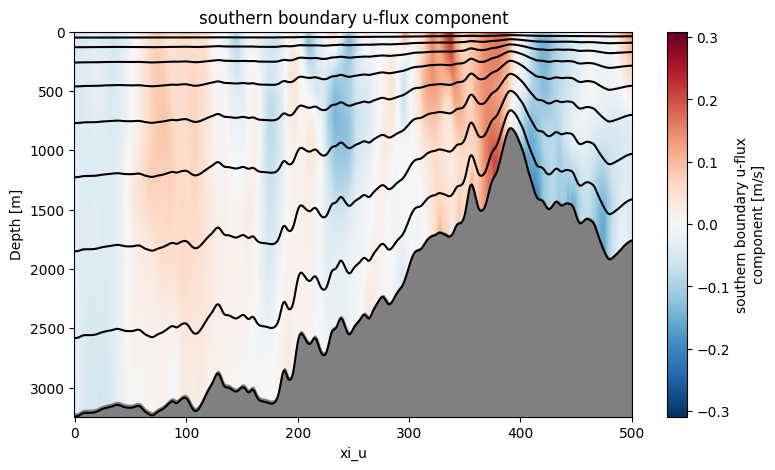

In [10]:
boundary_forcing.plot("u_south", time=0, layer_contours=True)

Note that even though we have a total of 100 layers, `layer_contours = True` will create a plot with a maximum of 10 contours to ensure plot clarity.

[########################################] | 100% Completed | 302.64 ms


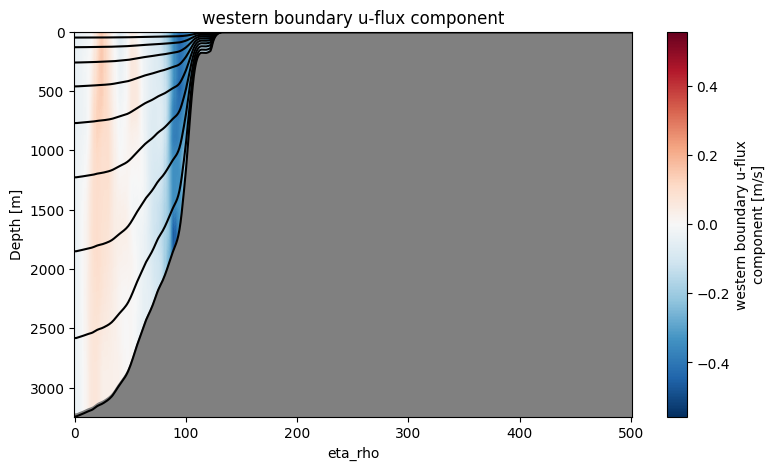

In [11]:
boundary_forcing.plot("u_west", time=0, layer_contours=True)

Sea surface height `zeta` at any of the boundaries and for a specific time is only a 1D variable.

[########################################] | 100% Completed | 101.17 ms


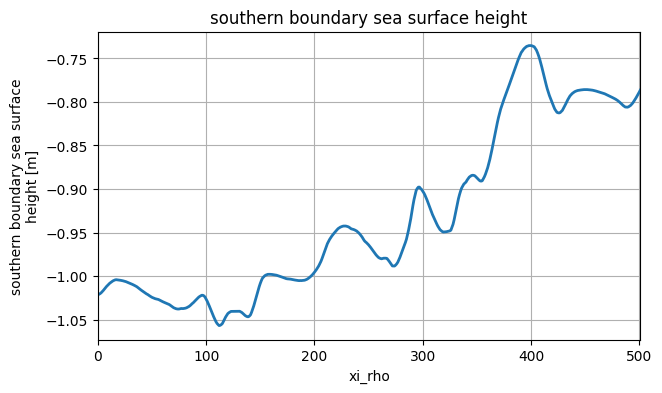

In [12]:
boundary_forcing.plot("zeta_south", time=0)

The same is true for the barotropic velocity `ubar`.

[########################################] | 100% Completed | 306.08 ms


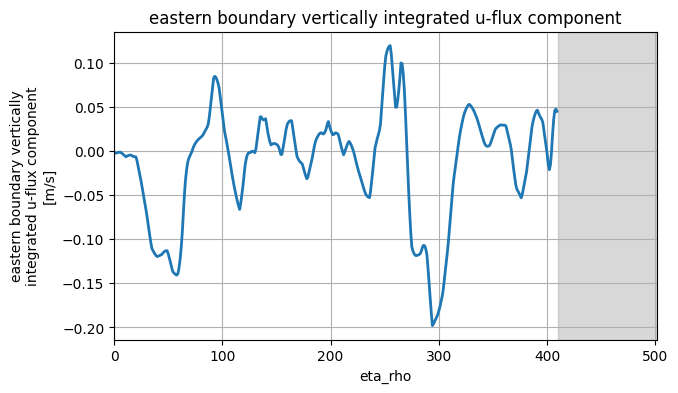

In [13]:
boundary_forcing.plot("ubar_east", time=0)

### Using Local Pre-Downloaded ERA5 Data
Next, let's make the same boundary forcing but using pre-downloaded GLORYS data sitting at the following location.

In [ ]:
glorys_path = [
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120129.nc",  # include data from day before start time
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120130.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120131.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120201.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120202.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120203.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120204.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120205.nc",  # include data from day after end time
]

<div class="alert alert-info">

Note

We could have also specified the data location via a wildcard, e.g., `glorys_path="/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/*.nc"`. But with this latter choice, `ROMS-Tools` will operate quite a bit slower. More specific filenames are better!

</div>

You can also download your own GLORYS data, which must span the desired ROMS domain and temporal range. For more details, please refer to [this page](https://roms-tools.readthedocs.io/en/latest/datasets.html).

In [ ]:
%%time

boundary_forcing_from_local_data = BoundaryForcing(
    **boundary_forcing_kwargs,
    source={"name": "GLORYS", "path": glorys_path},
    use_dask=True,
)

Instantiating the boundary forcing was much faster this time (just over 10 seconds) because it did not require streaming data.

In [8]:
boundary_forcing_from_local_data.ds

<xarray.Dataset> Size: 17MB
Dimensions:     (bry_time: 7, s_rho: 100, xi_u: 501, xi_rho: 502, eta_rho: 502,
                 eta_v: 501)
Coordinates:
    abs_time    (bry_time) datetime64[ns] 56B 2012-01-29T12:00:00 ... 2012-02...
  * bry_time    (bry_time) float64 56B 4.412e+03 4.412e+03 ... 4.418e+03
Dimensions without coordinates: s_rho, xi_u, xi_rho, eta_rho, eta_v
Data variables: (12/21)
    u_south     (bry_time, s_rho, xi_u) float32 1MB dask.array<chunksize=(1, 100, 501), meta=np.ndarray>
    v_south     (bry_time, s_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 100, 502), meta=np.ndarray>
    temp_south  (bry_time, s_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 100, 502), meta=np.ndarray>
    salt_south  (bry_time, s_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 100, 502), meta=np.ndarray>
    zeta_south  (bry_time, xi_rho) float32 14kB dask.array<chunksize=(1, 502), meta=np.ndarray>
    ubar_south  (bry_time, xi_u) float32 14kB dask.array<chunksize=(1, 501), meta=np.ndarray>
    ...          ...
    v_west      (bry_time, s_rho, eta_v) float32 1MB dask.array<chunksize=(1, 100, 501), meta=np.ndarray>
    temp_west   (bry_time, s_rho, eta_rho) float32 1MB dask.array<chunksize=(1, 100, 502), meta=np.ndarray>
    salt_west   (bry_time, s_rho, eta_rho) float32 1MB dask.array<chunksize=(1, 100, 502), meta=np.ndarray>
    zeta_west   (bry_time, eta_rho) float32 14kB dask.array<chunksize=(1, 502), meta=np.ndarray>
    ubar_west   (bry_time, eta_rho) float32 14kB dask.array<chunksize=(1, 502), meta=np.ndarray>
    vbar_west   (bry_time, eta_v) float32 14kB dask.array<chunksize=(1, 501), meta=np.ndarray>
Attributes:
    title:                                ROMS boundary forcing file created ...
    roms_tools_version:                   2.6.3.dev44+g780e06f.d20250623
    start_time:                           2012-01-30 00:00:00
    end_time:                             2012-02-04 00:00:00
    source:                               GLORYS
    model_reference_date:                 2000-01-01 00:00:00
    apply_2d_horizontal_fill:             False
    adjust_depth_for_sea_surface_height:  False
    theta_s:                              5.0
    theta_b:                              2.0
    hc:                                   300.0

## Adjusting the depth for sea surface height

`ROMS` uses a [terrain-following vertical coordinate system](https://roms-tools.readthedocs.io/en/latest/methods.html#vertical-coordinate-system). 
To regrid data from the depth coordinate of datasets like GLORYS onto the terrain-following ROMS coordinate system, `ROMS-Tools` internally computes the depth coordinates for the ROMS vertical coordinate system. The handling of sea surface height (SSH) depends on the value of the `adjust_depth_for_sea_surface_height` parameter:

* If `adjust_depth_for_sea_surface_height = False` (default), a constant sea surface height is assumed: $\zeta(x,y,t) = 0$.
* If `adjust_depth_for_sea_surface_height = True`, the depth calculations account for spatial and temporal variations in SSH.

When `adjust_depth_for_sea_surface_height = True`, the depths become time-dependent. While this approach may seem more accurate, its effectiveness depends on how source datasets (e.g., GLORYS) define their depth coordinates. It is often unclear whether these datasets measure depth relative to the surface (consistent with `adjust_depth_for_sea_surface_height = False`) or elevation above the bottom (consistent with `adjust_depth_for_sea_surface_height = True`). Given this uncertainty and the unclear benefit of adjusting for sea surface height variations, the default setting is `adjust_depth_for_sea_surface_height = False` for simplicity, and this approach has been used until now in this notebook.

<div class="alert alert-info">

Note

`adjust_depth_for_sea_surface_height = True` is only applicable for physical boundary forcing (`type="physics"`), as biogeochemical boundary forcing (`type="bgc"`) typically does not include sea surface height (SSH) information.

</div>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
Now, let's proceed by setting `adjust_depth_for_sea_surface_height = True` when generating the physical boundary forcing.                                                                                              

In [14]:
%%time

boundary_forcing_adjusted_for_ssh = BoundaryForcing(
    **boundary_forcing_kwargs,
    source={"name": "GLORYS", "path": glorys_path},
    use_dask=True,
    adjust_depth_for_sea_surface_height=True,
)

INFO - Sea surface height will be used to adjust depth coordinates.
INFO - Applying 1D horizontal fill to southern boundary.
INFO - Applying 1D horizontal fill to eastern boundary.
INFO - Applying 1D horizontal fill to western boundary.


CPU times: user 5.18 s, sys: 2.09 s, total: 7.27 s
Wall time: 6.2 s


When making a plot as described above, it is hard to see a difference by eye. This outcome is expected due to the subtle nature of the sea surface height adjustments.

[########################################] | 100% Completed | 305.26 ms


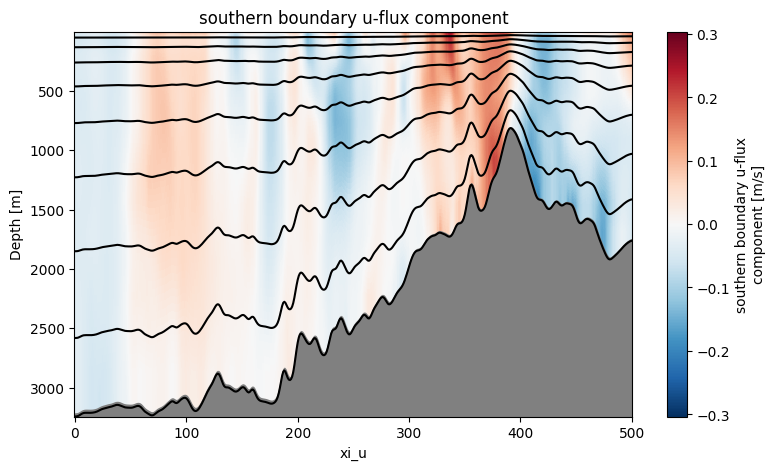

In [15]:
boundary_forcing_adjusted_for_ssh.plot("u_south", time=0, layer_contours=True)

Let's plot the differences directly.

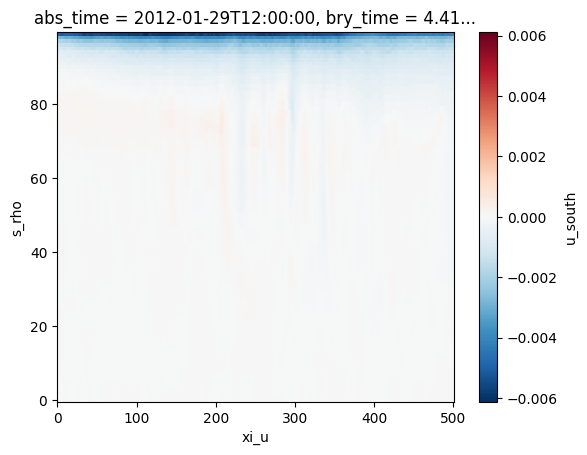

In [16]:
(boundary_forcing_adjusted_for_ssh.ds["u_south"] - boundary_forcing_from_local_data.ds["u_south"]).isel(
    bry_time=0
).plot()

The plot above confirms that the differences are subtle and primarily affect the surface layers.

## Biogeochemical (BGC) boundary forcing
We now create BGC boundary forcing. The BGC variables are interpolated from a climatology with 1° horizontal resolution, using two different approaches: 

1. **CESM BGC climatology**
2. **A unified BGC climatology** combining multiple observationally and model based sources:  
     - Nutrient concentrations (nitrate, phosphate, silicate) and dissolved oxygen from the 2018 World Ocean Atlas  
     - Dissolved iron and nitrous oxide from in-situ measurements  
     - Dissolved inorganic carbon (DIC) and alkalinity from the global GLODAPv2 product
     - Remaining nutrients (ammonium, nitrite, and organic nitrogen) and dissolved organic matter from CESM model simulations

Both BGC climatologies can be accessed at the following locations:  

In [17]:
cesm_bgc_path = "/global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-climatology_lowres_regridded.nc"
unified_bgc_path = "/global/cfs/projectdirs/m4746/Datasets/UNIFIED/BGCdataset.nc"

In [18]:
%%time

cesm_bgc_boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    boundaries={
        "south": True,
        "east": True,
        "north": False,  # northern boundary excluded
        "west": True,
    },
    source={"name": "CESM_REGRIDDED", "path": cesm_bgc_path, "climatology": True},
    type="bgc",
    use_dask=True,
)

INFO - Sea surface height will NOT be used to adjust depth coordinates.
INFO - Applying 1D horizontal fill to southern boundary.
INFO - Applying 1D horizontal fill to eastern boundary.
INFO - Applying 1D horizontal fill to western boundary.


CPU times: user 5.09 s, sys: 660 ms, total: 5.75 s
Wall time: 6.79 s


In [19]:
cesm_bgc_boundary_forcing.ds

<xarray.Dataset> Size: 231MB
Dimensions:            (bry_time: 12, s_rho: 100, xi_rho: 502, eta_rho: 502)
Coordinates:
    month              (bry_time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    abs_time           (bry_time) datetime64[ns] 96B 2000-01-16 ... 2000-12-15
  * bry_time           (bry_time) float64 96B 15.0 45.0 74.0 ... 319.0 349.0
Dimensions without coordinates: s_rho, xi_rho, eta_rho
Data variables: (12/96)
    PO4_south          (bry_time, s_rho, xi_rho) float32 2MB dask.array<chunksize=(12, 100, 502), meta=np.ndarray>
    NO3_south          (bry_time, s_rho, xi_rho) float32 2MB dask.array<chunksize=(12, 100, 502), meta=np.ndarray>
    SiO3_south         (bry_time, s_rho, xi_rho) float32 2MB dask.array<chunksize=(12, 100, 502), meta=np.ndarray>
    NH4_south          (bry_time, s_rho, xi_rho) float32 2MB dask.array<chunksize=(12, 100, 502), meta=np.ndarray>
    Fe_south           (bry_time, s_rho, xi_rho) float32 2MB dask.array<chunksize=(12, 100, 502), meta=np.ndarray>
    Lig_south          (bry_time, s_rho, xi_rho) float32 2MB dask.array<chunksize=(12, 100, 502), meta=np.ndarray>
    ...                 ...
    diazChl_west       (bry_time, s_rho, eta_rho) float32 2MB dask.array<chunksize=(12, 100, 502), meta=np.ndarray>
    diazC_west         (bry_time, s_rho, eta_rho) float32 2MB dask.array<chunksize=(12, 100, 502), meta=np.ndarray>
    diazP_west         (bry_time, s_rho, eta_rho) float32 2MB dask.array<chunksize=(12, 100, 502), meta=np.ndarray>
    diazFe_west        (bry_time, s_rho, eta_rho) float32 2MB dask.array<chunksize=(12, 100, 502), meta=np.ndarray>
    spCaCO3_west       (bry_time, s_rho, eta_rho) float32 2MB dask.array<chunksize=(12, 100, 502), meta=np.ndarray>
    zooC_west          (bry_time, s_rho, eta_rho) float32 2MB dask.array<chunksize=(12, 100, 502), meta=np.ndarray>
Attributes:
    title:                                ROMS boundary forcing file created ...
    roms_tools_version:                   2.6.3.dev44+g780e06f.d20250623
    start_time:                           2012-01-30 00:00:00
    end_time:                             2012-02-04 00:00:00
    source:                               CESM_REGRIDDED
    model_reference_date:                 2000-01-01 00:00:00
    apply_2d_horizontal_fill:             False
    adjust_depth_for_sea_surface_height:  False
    theta_s:                              5.0
    theta_b:                              2.0
    hc:                                   300.0
    climatology:                          True

In [20]:
%%time

unified_bgc_boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    boundaries={
        "south": True,
        "east": True,
        "north": False,  # northern boundary excluded
        "west": True,
    },
    source={"name": "UNIFIED", "path": unified_bgc_path, "climatology": True},
    type="bgc",
    use_dask=True,
)

INFO - Sea surface height will NOT be used to adjust depth coordinates.


CPU times: user 4.44 s, sys: 312 ms, total: 4.75 s
Wall time: 5.24 s


In [21]:
unified_bgc_boundary_forcing.ds

<xarray.Dataset> Size: 231MB
Dimensions:            (bry_time: 12, s_rho: 100, xi_rho: 502, eta_rho: 502)
Coordinates:
    month              (bry_time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    abs_time           (bry_time) datetime64[ns] 96B 2000-01-16T12:00:00 ... ...
  * bry_time           (bry_time) float64 96B 15.5 45.0 74.5 ... 319.0 349.5
Dimensions without coordinates: s_rho, xi_rho, eta_rho
Data variables: (12/96)
    PO4_south          (bry_time, s_rho, xi_rho) float32 2MB dask.array<chunksize=(2, 100, 502), meta=np.ndarray>
    NO3_south          (bry_time, s_rho, xi_rho) float32 2MB dask.array<chunksize=(2, 100, 502), meta=np.ndarray>
    SiO3_south         (bry_time, s_rho, xi_rho) float32 2MB dask.array<chunksize=(2, 100, 502), meta=np.ndarray>
    Fe_south           (bry_time, s_rho, xi_rho) float32 2MB dask.array<chunksize=(2, 100, 502), meta=np.ndarray>
    O2_south           (bry_time, s_rho, xi_rho) float32 2MB dask.array<chunksize=(2, 100, 502), meta=np.ndarray>
    DIC_south          (bry_time, s_rho, xi_rho) float32 2MB dask.array<chunksize=(2, 100, 502), meta=np.ndarray>
    ...                 ...
    diazFe_west        (bry_time, s_rho, eta_rho) float32 2MB dask.array<chunksize=(2, 100, 502), meta=np.ndarray>
    spCaCO3_west       (bry_time, s_rho, eta_rho) float32 2MB dask.array<chunksize=(2, 100, 502), meta=np.ndarray>
    zooC_west          (bry_time, s_rho, eta_rho) float32 2MB dask.array<chunksize=(2, 100, 502), meta=np.ndarray>
    Lig_west           (bry_time, s_rho, eta_rho) float32 2MB dask.array<chunksize=(2, 100, 502), meta=np.ndarray>
    DIC_ALT_CO2_west   (bry_time, s_rho, eta_rho) float32 2MB dask.array<chunksize=(2, 100, 502), meta=np.ndarray>
    ALK_ALT_CO2_west   (bry_time, s_rho, eta_rho) float32 2MB dask.array<chunksize=(2, 100, 502), meta=np.ndarray>
Attributes:
    title:                                ROMS boundary forcing file created ...
    roms_tools_version:                   2.6.3.dev44+g780e06f.d20250623
    start_time:                           2012-01-30 00:00:00
    end_time:                             2012-02-04 00:00:00
    source:                               UNIFIED
    model_reference_date:                 2000-01-01 00:00:00
    apply_2d_horizontal_fill:             False
    adjust_depth_for_sea_surface_height:  False
    theta_s:                              5.0
    theta_b:                              2.0
    hc:                                   300.0
    climatology:                          True

Let's investigate the time variable of our datasets.

In [22]:
cesm_bgc_boundary_forcing.ds["bry_time"]

<xarray.DataArray 'bry_time' (bry_time: 12)> Size: 96B
array([ 15.,  45.,  74., 105., 135., 166., 196., 227., 258., 288., 319., 349.])
Coordinates:
    month     (bry_time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    abs_time  (bry_time) datetime64[ns] 96B 2000-01-16 2000-02-15 ... 2000-12-15
  * bry_time  (bry_time) float64 96B 15.0 45.0 74.0 105.0 ... 288.0 319.0 349.0
Attributes:
    cycle_length:  365.25
    long_name:     relative time: days since 2000-01-01 00:00:00
    units:         days

In [23]:
unified_bgc_boundary_forcing.ds["bry_time"]

<xarray.DataArray 'bry_time' (bry_time: 12)> Size: 96B
array([ 15.5,  45. ,  74.5, 105. , 135.5, 166. , 196. , 227.5, 258. , 288.5,
       319. , 349.5])
Coordinates:
    month     (bry_time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    abs_time  (bry_time) datetime64[ns] 96B 2000-01-16T12:00:00 ... 2000-12-1...
  * bry_time  (bry_time) float64 96B 15.5 45.0 74.5 105.0 ... 288.5 319.0 349.5
Attributes:
    cycle_length:  365.25
    long_name:     relative time: days since 2000-01-01 00:00:00
    units:         days

<div class="alert alert-info">

Note

The datasets `cesm_bgc_boundary_forcing.ds` and `unified_bgc_boundary_forcing.ds` contain twelve time entries because their respective source is a climatology, as we specified via `source["climatology"] = True`.

For climatologies, `ROMS-Tools` does not subsample the twelve time entries further, regardless of the provided start and end time. Note that the `bry_time` coordinate has an additional attribute: `cycle_length` (with units in days). This attribute will tell ROMS to repeat the climatology every 365.25 days. In other words, the data in `bgc_boundary_forcing.ds` will work for ROMS run over any time window (as long as the model reference date is January 1, xxxx).

</div>

We can plot the BGC boundary forcing as we saw above.

[########################################] | 100% Completed | 504.02 ms


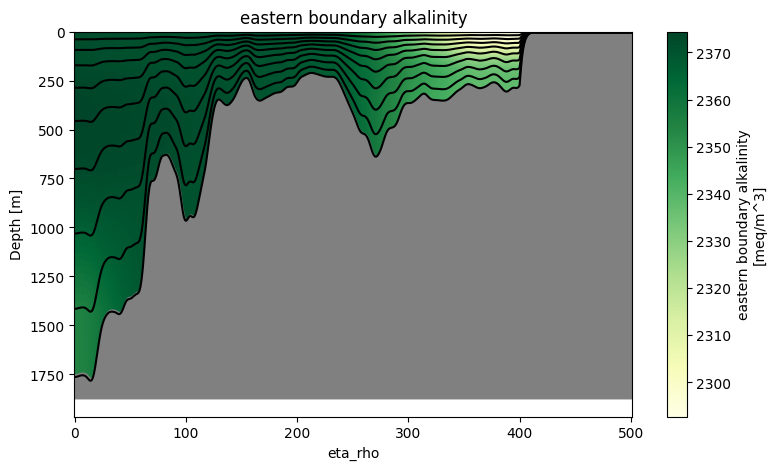

In [24]:
cesm_bgc_boundary_forcing.plot("ALK_east", time=0, layer_contours=True)

[########################################] | 100% Completed | 202.47 ms


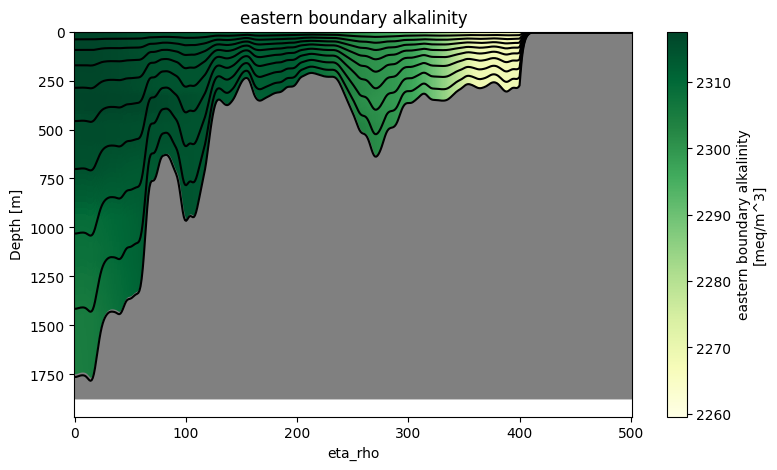

In [25]:
unified_bgc_boundary_forcing.plot("ALK_east", time=0, layer_contours=True)

## Saving as NetCDF or YAML file
We can now save our boundary forcings as a NetCDF files. 

We need to specify the desired target path.

In [26]:
filepath = "/pscratch/sd/n/nloose/forcing/my_bgc_boundary_forcing.nc"

In [27]:
%time cesm_bgc_boundary_forcing.save(filepath)

INFO - Writing the following NetCDF files:
/pscratch/sd/n/nloose/forcing/my_bgc_boundary_forcing_clim.nc


[########################################] | 100% Completed | 8.67 ss
CPU times: user 46.6 s, sys: 30.1 s, total: 1min 16s
Wall time: 9.1 s


[PosixPath('/pscratch/sd/n/nloose/forcing/my_bgc_boundary_forcing_clim.nc')]

Next, let's save the physical boundary forcing. We will use the `group = True` flag (default) which ensures that the data is split into multiple NetCDFs, grouped into months.

In [28]:
filepath = "/pscratch/sd/n/nloose/forcing/my_boundary_forcing.nc"

In [29]:
%time boundary_forcing.save(filepath, group=True)

INFO - Writing the following NetCDF files:
/pscratch/sd/n/nloose/forcing/my_boundary_forcing_201201.nc
/pscratch/sd/n/nloose/forcing/my_boundary_forcing_201202.nc


[########################################] | 100% Completed | 1.34 sms
[########################################] | 100% Completed | 1.85 sms
CPU times: user 8.86 s, sys: 3.64 s, total: 12.5 s
Wall time: 3.75 s


[PosixPath('/pscratch/sd/n/nloose/forcing/my_boundary_forcing_201201.nc'),
 PosixPath('/pscratch/sd/n/nloose/forcing/my_boundary_forcing_201202.nc')]

From the file paths printed to the screen, you will notice that the year and month information has been appended to the specified path.

<div class="alert alert-info">

Note

The way data is grouped depends on its temporal frequency. For datasets with a daily or higher frequency, the data is grouped by month. For datasets with lower temporal frequency (e.g., monthly data), the grouping is done by year.

</div>

We can also export the parameters of our `BoundaryForcing` object to a YAML file.

In [30]:
yaml_filepath = "/pscratch/sd/n/nloose/forcing/my_boundary_forcing.yaml"

In [31]:
boundary_forcing.to_yaml(yaml_filepath)

This is the YAML file that was created.

In [32]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 2.6.3.dev44+g780e06f.d20250623
---
Grid:
  nx: 500
  ny: 500
  size_x: 1000
  size_y: 1000
  center_lon: -37
  center_lat: 64
  rot: 25
  N: 100
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source:
    name: SRTM15
    path: /global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc
  hmin: 5.0
BoundaryForcing:
  start_time: '2012-01-30T00:00:00'
  end_time: '2012-02-04T00:00:00'
  boundaries:
    south: true
    east: true
    north: false
    west: true
  source:
    name: GLORYS
    path:
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120129.nc
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120130.nc
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120131.nc
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120201.nc
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mer

## Creating boundary forcing from an existing YAML file

In [33]:
%time the_same_boundary_forcing = BoundaryForcing.from_yaml(yaml_filepath, use_dask=True)

INFO - Sea surface height will NOT be used to adjust depth coordinates.
INFO - Applying 1D horizontal fill to southern boundary.
INFO - Applying 1D horizontal fill to eastern boundary.
INFO - Applying 1D horizontal fill to western boundary.


CPU times: user 7.94 s, sys: 2.28 s, total: 10.2 s
Wall time: 10.2 s


In [34]:
the_same_boundary_forcing.ds

<xarray.Dataset> Size: 17MB
Dimensions:     (bry_time: 7, s_rho: 100, xi_u: 501, xi_rho: 502, eta_rho: 502,
                 eta_v: 501)
Coordinates:
    abs_time    (bry_time) datetime64[ns] 56B 2012-01-29T12:00:00 ... 2012-02...
  * bry_time    (bry_time) float64 56B 4.412e+03 4.412e+03 ... 4.418e+03
Dimensions without coordinates: s_rho, xi_u, xi_rho, eta_rho, eta_v
Data variables: (12/21)
    u_south     (bry_time, s_rho, xi_u) float32 1MB dask.array<chunksize=(1, 100, 501), meta=np.ndarray>
    v_south     (bry_time, s_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 100, 502), meta=np.ndarray>
    temp_south  (bry_time, s_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 100, 502), meta=np.ndarray>
    salt_south  (bry_time, s_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 100, 502), meta=np.ndarray>
    zeta_south  (bry_time, xi_rho) float32 14kB dask.array<chunksize=(1, 502), meta=np.ndarray>
    ubar_south  (bry_time, xi_u) float32 14kB dask.array<chunksize=(1, 501), meta=np.ndarray>
    ...          ...
    v_west      (bry_time, s_rho, eta_v) float32 1MB dask.array<chunksize=(1, 100, 501), meta=np.ndarray>
    temp_west   (bry_time, s_rho, eta_rho) float32 1MB dask.array<chunksize=(1, 100, 502), meta=np.ndarray>
    salt_west   (bry_time, s_rho, eta_rho) float32 1MB dask.array<chunksize=(1, 100, 502), meta=np.ndarray>
    zeta_west   (bry_time, eta_rho) float32 14kB dask.array<chunksize=(1, 502), meta=np.ndarray>
    ubar_west   (bry_time, eta_rho) float32 14kB dask.array<chunksize=(1, 502), meta=np.ndarray>
    vbar_west   (bry_time, eta_v) float32 14kB dask.array<chunksize=(1, 501), meta=np.ndarray>
Attributes:
    title:                                ROMS boundary forcing file created ...
    roms_tools_version:                   2.6.3.dev44+g780e06f.d20250623
    start_time:                           2012-01-30 00:00:00
    end_time:                             2012-02-04 00:00:00
    source:                               GLORYS
    model_reference_date:                 2000-01-01 00:00:00
    apply_2d_horizontal_fill:             False
    adjust_depth_for_sea_surface_height:  False
    theta_s:                              5.0
    theta_b:                              2.0
    hc:                                   300.0

## 1D versus 2D horizontal fill

The horizontal fill process controls how ocean values are extended into land regions. This matters when the source data (such as GLORYS) and the ROMS grid have differing land masks, often due to different resolutions.
Without applying horizontal fill, land mask discrepancies could lead to NaN values at certain ocean points in the ROMS grid, where the source data (GLORYS) considers them land.

When creating the boundary forcing, users can select between two horizontal fill methods:

* **1D Horizontal Fill** (`apply_2d_horizontal_fill = False`): This method applies extrapolation along each boundary edge individually after regridding, using a [forward fill](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.ffill.html) followed by a [backward fill](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.bfill.html) to fill missing values.
* **2D Horizontal Fill** (`apply_2d_horizontal_fill = True`): This method fills missing values across the grid using a 2D diffusion AMG (Algebraic Multigrid) algorithm before the regridding step, allowing for more spatially smooth and consistent coverage across the entire area.

Note that the two methods coincide for boundaries that are entirely over open ocean (without any land interference).

<img src="images/horizontal_fill.png" alt="Horizontal fill" width="1000"/>

The **1D horizontal fill** method is **faster** and the **default** choice. The 2D horizontal fill, while more thorough, is slower as it fills an entire 2D domain at each depth level, often covering interior areas that won’t ultimately be used for the boundary forcing. For example, in the scenario above, the 2D fill would extend values across both Iceland and Greenland.

<div class="alert alert-info">

Note

To minimize unnecessary calculations, `ROMS-Tools` limits the 2D fill to a small area surrounding the target ROMS domain, so it wouldn't fill the entire North Atlantic in the scenario above. However, a buffer zone around the target ROMS domain is included to avoid edge artifacts from the 2D fill near the boundaries.
    
</div>

However, the 1D fill method may **not** be **safe in all situations**. Its **limitations** include:

* **Land Segments Dividing a Boundary Segment**: When land segments divide a boundary segment, the 1D fill method may extend values across the land, from one end to the other, potentially leading to unphysical effects. In such cases, `ROMS-Tools` will issue a warning suggesting that the 2D fill method is a safer alternative. We will explore such an example in Case study 1 below.
* **Coarse Resolution of Source Data**: If the source data has a coarse resolution, a boundary segment may appear entirely on land in the source data, even though it crosses into the ocean in the target ROMS domain. For such segments, the 1D fill method is unable to properly fill NaNs and will raise an error. In contrast, the 2D fill method applies a spatial diffusion algorithm before regridding, thus providing a reliable solution. This scenario will be explored in Case study 2 below.

### Case study 1: Land segments dividing a boundary section

Let's examine an example with an island in the boundary to better understand the first limitation of the 1D fill method.

In [35]:
grid = Grid(
    nx=100,
    ny=100,
    size_x=1000,
    size_y=1000,
    center_lon=-31,
    center_lat=64,
    rot=25,
    topography_source={
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    },
)

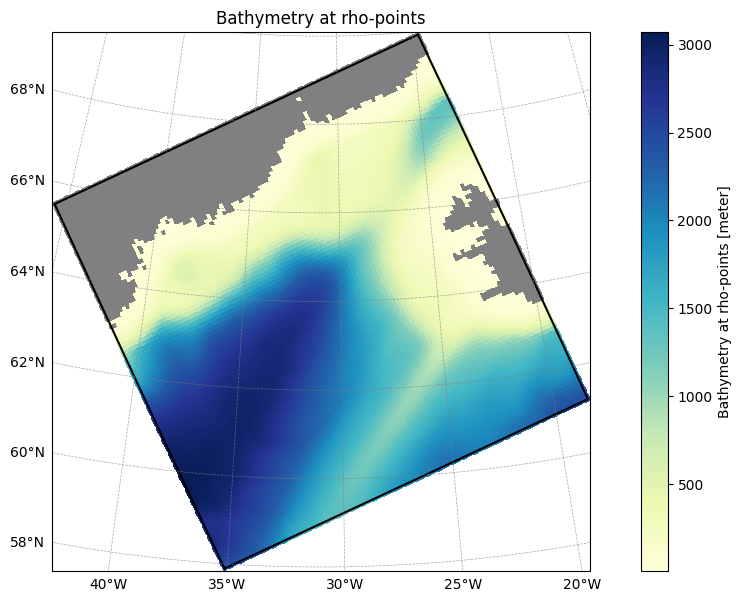

In [36]:
grid.plot()

The eastern boundary is divided by Iceland!

We now create the boundary forcing twice, once with a 1D horizontal fill, and once with a 2D horizontal fill. By choosing `use_dask = False`, we trigger computation upon creating these two objects, and we can get a comparison of the timings.

In [37]:
kwargs = {
    "grid": grid,
    "start_time": start_time,
    "end_time": end_time,
    "boundaries": {
        "south": True,
        "east": True,
        "north": True,
        "west": True,
    },
    "source": {"name": "GLORYS", "path": glorys_path},
    "use_dask": False,
}

<div class="alert alert-info">

Note
    
In this example, the northern boundary is entirely over land, which means we could exclude it from the boundary generation by setting `boundaries = {"south": True, "east": True, "north": False, "west": True}`. However, we keep the northern boundary in this demonstration to illustrate the `ROMS-Tools` behavior when an entire boundary edge lies over land.

</div>

In [38]:
%%time

boundary_forcing_with_1d_fill = BoundaryForcing(
    **kwargs,
    apply_2d_horizontal_fill=False,
)

INFO - Sea surface height will NOT be used to adjust depth coordinates.
INFO - Applying 1D horizontal fill to southern boundary.
INFO - Applying 1D horizontal fill to eastern boundary.
WARNING - For u, the eastern boundary is divided by land. It would be safer (but slower) to use `apply_2d_horizontal_fill = True`.
WARNING - For v, the eastern boundary is divided by land. It would be safer (but slower) to use `apply_2d_horizontal_fill = True`.
WARNING - For temp, the eastern boundary is divided by land. It would be safer (but slower) to use `apply_2d_horizontal_fill = True`.
WARNING - For zeta, the eastern boundary is divided by land. It would be safer (but slower) to use `apply_2d_horizontal_fill = True`.
INFO - Applying 1D horizontal fill to northern boundary.
INFO - Applying 1D horizontal fill to western boundary.


CPU times: user 4.73 s, sys: 2.45 s, total: 7.17 s
Wall time: 9.19 s


Fortunately, `ROMS-Tools` provides a warning for the eastern boundary, alerting us to the issue.

In [39]:
%%time

boundary_forcing_with_2d_fill = BoundaryForcing(
    **kwargs,
    apply_2d_horizontal_fill=True,
)

INFO - Sea surface height will NOT be used to adjust depth coordinates.
INFO - Applying 2D horizontal fill to the source data before regridding.


CPU times: user 41min 38s, sys: 3.11 s, total: 41min 41s
Wall time: 29.2 s


Creating the boundary forcing with the safer 2D horizontal fill took about 3 times as long as with the 1D horizontal fill. 

Let's compare the results! As an example, we will look at temperature along the four boundaries at the first time step.

In [40]:
import matplotlib.pyplot as plt

bdry_coords = {
    "south": {"eta_rho": 0},
    "east": {"xi_rho": -1},
    "north": {"eta_rho": -1},
    "west": {"xi_rho": 0},
}


def compare_fill_methods(
    direction,
    bry_time=0,
    bf_2d_fill=boundary_forcing_with_2d_fill,
    bf_1d_fill=boundary_forcing_with_1d_fill,
):

    fig, axs = plt.subplots(1, 3, figsize=(17, 3))

    var_name = "temp"
    kwargs = {"cbar_kwargs": {"label": "degrees Celsius"}}
    title = "Temperature"

    mask = grid.ds.mask_rho.isel(**bdry_coords[direction])

    bf_2d_fill.ds[f"{var_name}_{direction}"].isel(bry_time=bry_time).plot(
        ax=axs[0], **kwargs
    )
    axs[0].set_title("2D horizontal fill")
    bf_1d_fill.ds[f"{var_name}_{direction}"].isel(bry_time=bry_time).plot(
        ax=axs[1], **kwargs
    )
    axs[1].set_title("1D horizontal fill")
    (bf_2d_fill.ds - bf_1d_fill.ds)[f"{var_name}_{direction}"].where(mask).isel(
        bry_time=bry_time
    ).plot(ax=axs[2], **kwargs)
    axs[2].set_title("Difference at wet points")

    fig.suptitle(f"{title} at {direction}ern boundary", y=1.05)

    return fig

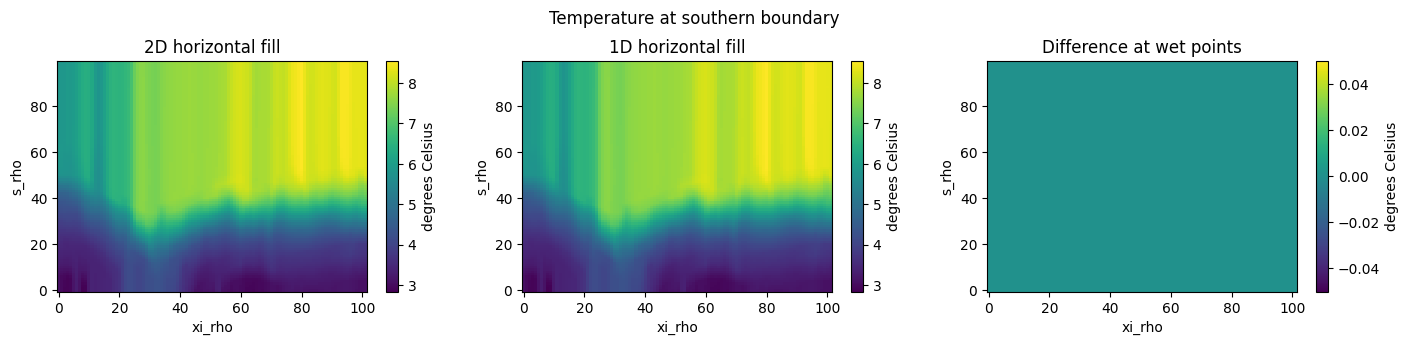

In [41]:
fig = compare_fill_methods("south")

The southern boundary does not contain any land points, so southern boundary temperature is the same for both fill methods, as expected.

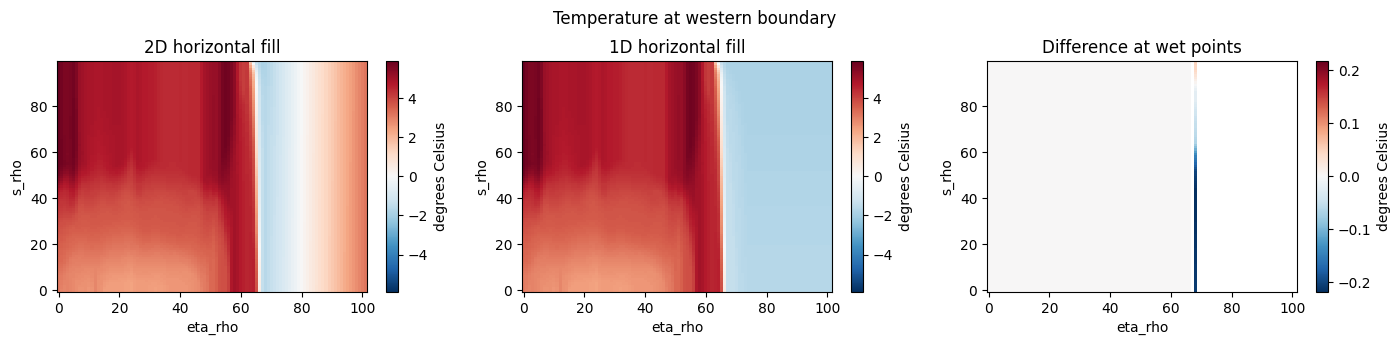

In [42]:
fig = compare_fill_methods("west")

The western boundary intersects Greenland for `eta_rho > 67`, where the fill values vary between the two fill methods. However, in this example, the values are nearly identical at most wet points, with only minor differences of up to 0.22$^\circ$C. As a result, the choice of fill method has a minimal impact on the ROMS online simulation outcome in this case.

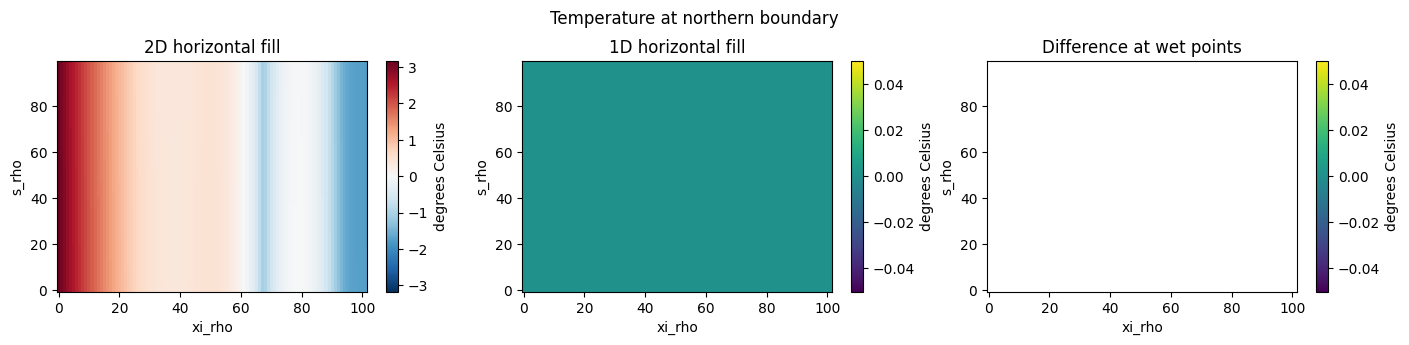

In [43]:
fig = compare_fill_methods("north")

The northern boundary lies entirely over land (Greenland), and might as well have been skipped in the boundary forcing generation. The fill values generated by the 2D fill are more sophisticated than those by the 1D fill (simply zero). But this won't have any influence on the online model.

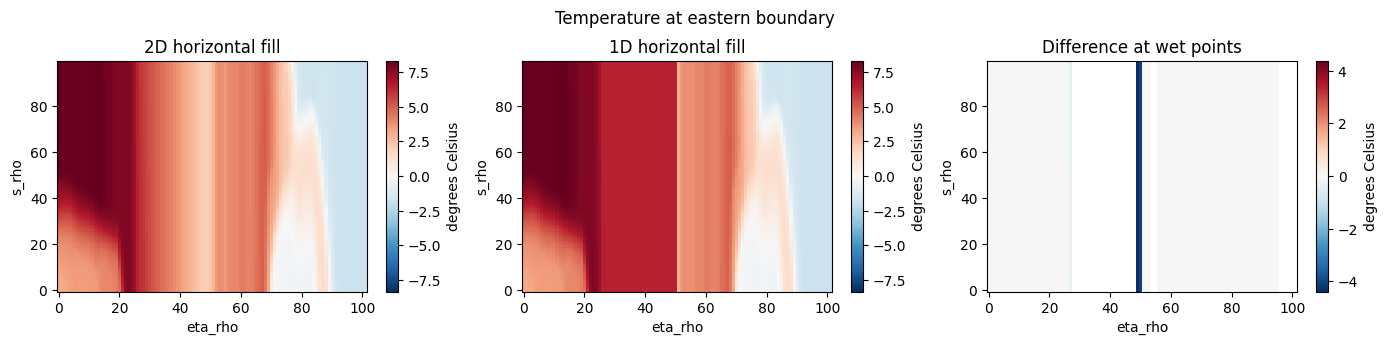

In [44]:
fig = compare_fill_methods("east")

The eastern boundary is divided by Iceland, highlighting one of the limitations of the 1D fill method. As noted earlier, the 1D fill applied a straightforward forward fill, which inadvertently spread values from the region south of Iceland to the region north of Iceland, creating an artifact in the eastern boundary data north of Iceland (at about `eta_rho` = 50). This is exactly what `ROMS-Tools` warned us about when we generated the boundary forcing with the 1D fill!

### Case study 2: Coarse resolution of source data

Let's examine an example where the resolution of the source data is very coarse to better understand the second limitation of the 1D fill method. First, we create a grid that encompasses the waters surrounding Wales.

In [45]:
grid = Grid(
    nx=30,
    ny=30,
    size_x=240,
    size_y=240,
    center_lon=-4.1,
    center_lat=52.36,
    rot=0,
    topography_source={
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    },
)

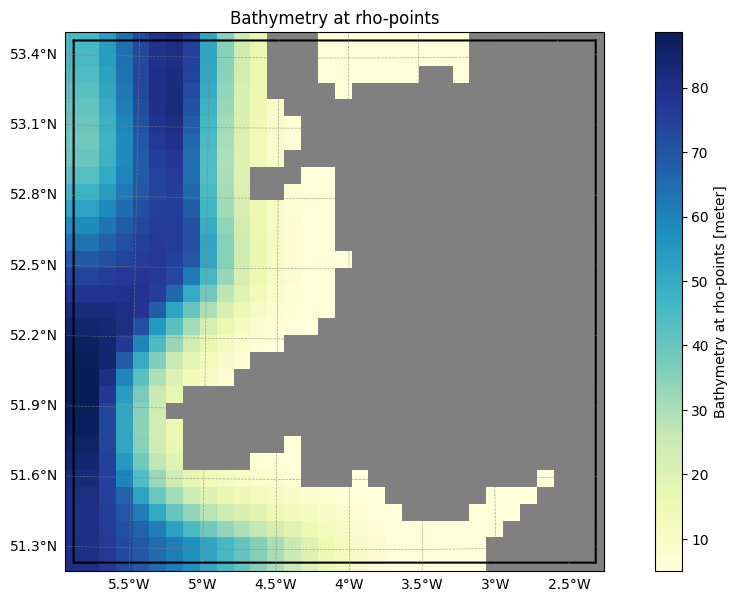

In [46]:
grid.plot()

The only boundary that lies entirely on land in the ROMS domain is the eastern boundary. Therefore, we can exclude the eastern boundary from the boundary forcing generation.

In [47]:
kwargs = {
    "grid": grid,
    "start_time": start_time,
    "end_time": end_time,
    "boundaries": {
        "south": True,
        "east": False,
        "north": True,
        "west": True,
    },
    "source": {"name": "CESM_REGRIDDED", "path": cesm_bgc_path, "climatology": True},
    "type": "bgc",
    "use_dask": False,
}

Before generating the boundary forcing, let's first examine the **source data** that we will be regridding: BGC data from a **coarse 1x1 degree** CESM simulation.

In [48]:
import xarray as xr

In [49]:
ds_source = xr.open_dataset(cesm_bgc_path)
ds_source

<xarray.Dataset> Size: 4GB
Dimensions:      (month: 12, z_t: 60, lat: 180, lon: 360, z_t_150m: 15)
Coordinates:
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * z_t          (z_t) float32 240B 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m     (z_t_150m) float32 60B 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * lon          (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat          (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables: (12/32)
    ALK          (month, z_t, lat, lon) float32 187MB ...
    ALK_ALT_CO2  (month, z_t, lat, lon) float32 187MB ...
    DIC          (month, z_t, lat, lon) float32 187MB ...
    DIC_ALT_CO2  (month, z_t, lat, lon) float32 187MB ...
    DOC          (month, z_t, lat, lon) float32 187MB ...
    DOCr         (month, z_t, lat, lon) float32 187MB ...
    ...           ...
    spC          (month, z_t_150m, lat, lon) float32 47MB ...
    spCaCO3      (month, z_t_150m, lat, lon) float32 47MB ...
    spChl        (month, z_t_150m, lat, lon) float32 47MB ...
    spFe         (month, z_t_150m, lat, lon) float32 47MB ...
    spP          (month, z_t_150m, lat, lon) float32 47MB ...
    zooC         (month, z_t_150m, lat, lon) float32 47MB ...
Attributes:
    Title:          Climatology computed from the 1x1 degree CESM-MARBL simul...
    original_path:  /glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI_BGC/L...
    regrid_method:  conservative

Here, we zoom in on the coarse CESM source data around the Wales domain of interest.

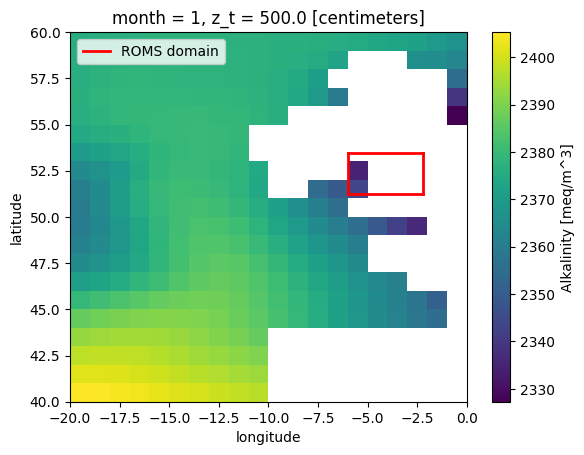

In [50]:
fig, ax = plt.subplots()
ds_source["ALK"].isel(z_t=0, month=0).sel(lat=slice(40, 60), lon=slice(-20, 0)).plot(
    ax=ax
)
ax.plot(
    [grid.ds.lon_rho.min() - 360, grid.ds.lon_rho.min() - 360],
    [grid.ds.lat_rho.min(), grid.ds.lat_rho.max()],
    color="r",
    linewidth=2,
)
ax.plot(
    [grid.ds.lon_rho.max() - 360, grid.ds.lon_rho.max() - 360],
    [grid.ds.lat_rho.min(), grid.ds.lat_rho.max()],
    color="r",
    linewidth=2,
)
ax.plot(
    [grid.ds.lon_rho.min() - 360, grid.ds.lon_rho.max() - 360],
    [grid.ds.lat_rho.min(), grid.ds.lat_rho.min()],
    color="r",
    linewidth=2,
)
ax.plot(
    [grid.ds.lon_rho.min() - 360, grid.ds.lon_rho.max() - 360],
    [grid.ds.lat_rho.max(), grid.ds.lat_rho.max()],
    color="r",
    linewidth=2,
    label="ROMS domain",
)
ax.legend(loc="upper left")

As shown in the figure above, all the boundaries of the ROMS domain lie almost entirely on land, with at most one ocean grid point per boundary. This is insufficient to generate valid regridded boundary values if the 2D horizontal fill prior to regridding is skipped, resulting in each boundary being populated entirely with NaN values. For this reason, `ROMS-Tools` raises an error if we try to use the 1D fill in this example, as seen in the next cell.

In [51]:
%%time

bgc_boundary_forcing_with_1d_fill = BoundaryForcing(
    **kwargs, apply_2d_horizontal_fill=False
)

INFO - Sea surface height will NOT be used to adjust depth coordinates.
INFO - Applying 1D horizontal fill to southern boundary.
INFO - Applying 1D horizontal fill to northern boundary.
INFO - Applying 1D horizontal fill to western boundary.


ValueError: ALK_south consists entirely of NaNs after regridding. This may be due to the southern boundary being on land in the CESM_REGRIDDED data, which could have a coarser resolution than the ROMS domain. Try setting `apply_2d_horizontal_fill = True` to resolve this issue.

Let's try the 2D horizontal fill instead, as suggested in the error message.

In [52]:
%%time

bgc_boundary_forcing_with_2d_fill = BoundaryForcing(
    **kwargs, apply_2d_horizontal_fill=True
)

INFO - Sea surface height will NOT be used to adjust depth coordinates.
INFO - Applying 2D horizontal fill to the source data before regridding.


CPU times: user 24.2 s, sys: 1.25 s, total: 25.4 s
Wall time: 34.5 s


This worked, and the boundary forcing has reasonable values.

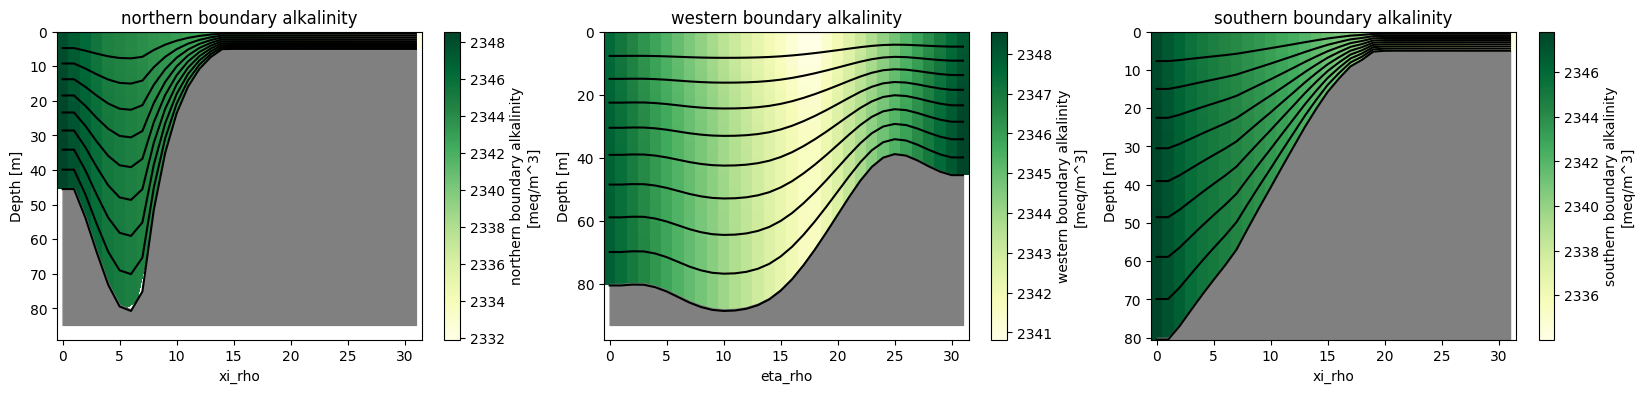

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

bgc_boundary_forcing_with_2d_fill.plot(f"ALK_north", layer_contours=True, ax=axs[0])
bgc_boundary_forcing_with_2d_fill.plot(f"ALK_west", layer_contours=True, ax=axs[1])
bgc_boundary_forcing_with_2d_fill.plot(f"ALK_south", layer_contours=True, ax=axs[2])